In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import astropy.units as u
import numpy as np
from astroduet.filters import load_qe, load_reflectivity, load_redfilter, apply_trans
from astroduet.zodi import load_zodi
from astroduet.config import Telescope

from astroduet.bbmag import bb_abmag_fluence

from matplotlib import pyplot as plt
%matplotlib inline
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

# Make duet Telescope instance
duet = Telescope()
duet.info()
zodi = load_zodi(scale=77)
ref_wave, reflectivity = load_reflectivity(duet.reflectivity_file['name'], diag=True)
pixel_area = duet.pixel **2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
-----
        DUET Telescope State: baseline
        Physical Entrance Pupil: 26.0 cm
        Effective EPD: 24.2 cm
        Effective Area: 459.9605804120816 cm2
        Transmission Efficiency: 0.8166518036622619
        
        Pixel size: 6.4 arcsec
        Pointing RMS: 2.5 arcsec
        DIQ RMS: 4.406714876186114 arcsec
        Effective PSF FWHM: 12.5 arcsec
        N_eff: 9.75310538172716

        Band 1: {'eff_wave': <Quantity 202.56878682 nm>, 'eff_width': <Quantity 53.32814342 nm>}
        Bandpass 1: [175.90471511 229.23285853] nm
        Band 2: {'eff_wave': <Quantity 281.7531854 nm>, 'eff_width': <Quantity 68.16239088 nm>}
        Bandpass 2: [247.67198996 315.83438085] nm

        Dark current: 0.0115 ph / s
        Read noise (RMS per read): 7
        -----
        
Optics reflectivity loader
Input file /Users/bwgref/science/local/git/duet-astro/astroduet/data/al_mgf2_mirror_coatin

In [5]:
# Version use by Telescope()
from astroduet.filters import filter_parameters
filter_parameters()

({'eff_wave': <Quantity 202.56878682 nm>,
  'eff_width': <Quantity 53.32814342 nm>},
 {'eff_wave': <Quantity 281.7531854 nm>,
  'eff_width': <Quantity 68.16239088 nm>})

Optics reflectivity loader
Input file /Users/bwgref/science/local/git/duet-astro/astroduet/data/al_mgf2_mirror_coatings.csv
Detector Q.E. loader
Band 1 has input file /Users/bwgref/science/local/git/duet-astro/astroduet/data/detector_180_220nm.csv
Red filter loader
Band 1 has input file /Users/bwgref/science/local/git/duet-astro/astroduet/data/duet1_filter_light.csv
['/Users/bwgref/science/local/git/duet-astro/astroduet/data/detector_180_220nm.csv', '/Users/bwgref/science/local/git/duet-astro/astroduet/data/detector_260_300nm.csv']


Text(0.5, 1.0, 'DUET1')

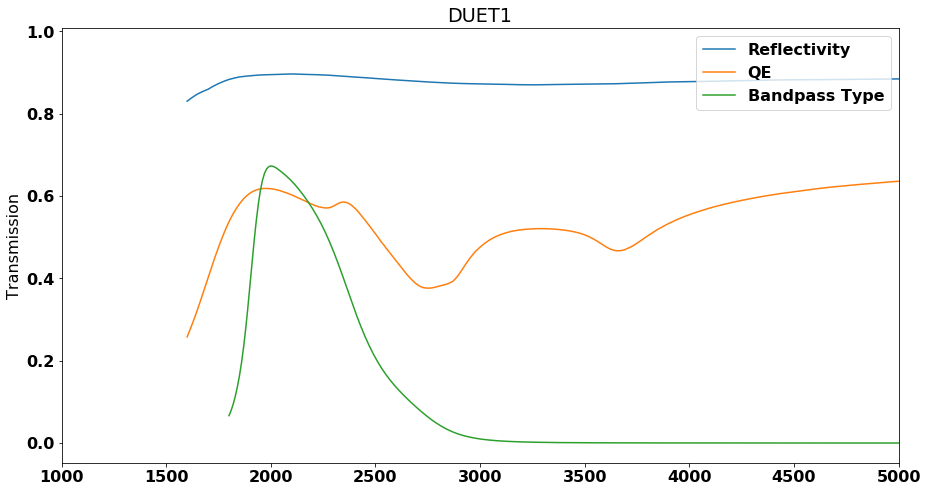

In [7]:
# Band 1

band_flux = duet.apply_filters(zodi['wavelength'], zodi['flux'], band=1, diag=True)

low_wave = duet.bandpass1[0]
high_wave = duet.bandpass1[1]

print(duet.qe_files['names'])
qe_wave, qe = load_qe(duet.qe_files['names'][0])

fig = plt.figure(figsize = (15, 8))
ax = fig.subplots()

ax.plot(ref_wave.to(u.AA), reflectivity, label='Reflectivity')
ax.plot(qe_wave.to(u.AA), qe, label="QE")



red_wave, red_trans = load_redfilter(duet.bandpass_files['names'][0])
ax.plot(red_wave.to(u.AA), red_trans, label='Bandpass Type')
    
    

ax.set_ylabel('Transmission')
ax.set_xlim([1000, 5000])
ax.legend(loc=1)
ax.set_title('DUET1')



Detector Q.E. loader
Band 1 has input file /Users/bwgref/science/local/git/duet-astro/astroduet/data/detector_260_300nm.csv


NameError: name 'airglow_lines' is not defined

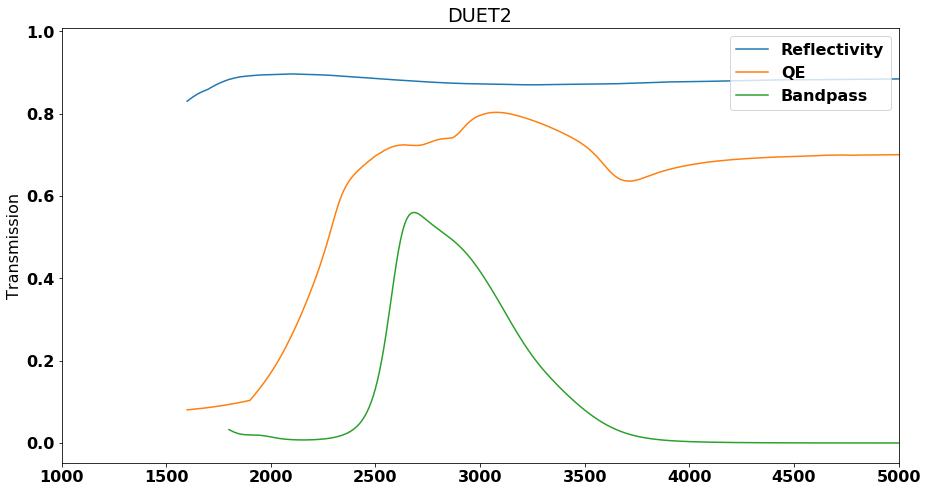

In [9]:
# Band 2
low_wave = duet.bandpass2[0]
high_wave = duet.bandpass2[1]

qe_wave, qe = load_qe(infile=duet.qe_files['names'][1], diag=True)

fig = plt.figure(figsize = (15, 8))
ax = fig.subplots()

ax.plot(ref_wave.to(u.AA), reflectivity, label='Reflectivity')
ax.plot(qe_wave.to(u.AA), qe, label="QE")



red_wave, red_trans = load_redfilter(duet.bandpass_files['names'][1])
ax.plot(red_wave.to(u.AA), red_trans, label='Bandpass')
    
ax.set_ylabel('Transmission')
ax.set_xlim([1000, 5000])
ax.legend(loc=1)
ax.set_title('DUET2')




o2_total = duet.apply_filters(zodi['wavelength'], airglow_lines, band=2)
print(o2_total.sum() / airglow_lines.sum())


----
1 0.8061152127186787 ph / s 0.29619920140053146 ph / s 0.0115 ph / s
----
2 0.9960051845660118 ph / s 2.4173934928805587 ph / s 0.0115 ph / s


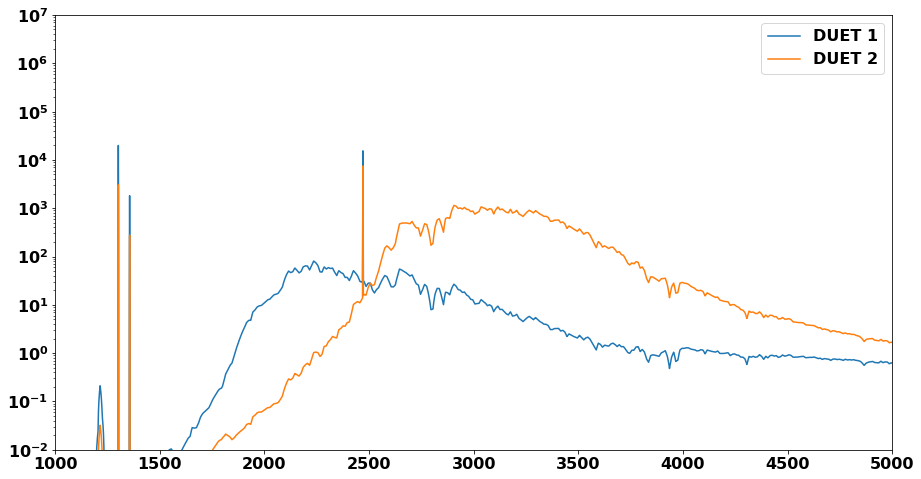

In [13]:
fig = plt.figure(figsize = (15, 8))
ax = fig.subplots()

for band in [1, 2]:
    print('----')
    band_flux = duet.apply_filters(zodi['wavelength'], zodi['flux'], band=band)
    ax.plot(zodi['wavelength'], band_flux, label = 'DUET {}'.format(band))

    de = zodi['wavelength'][1] - zodi['wavelength'][0]
    ph_flux = (de*band_flux).to(u.ph / ((u.cm**2 * u.arcsec**2 * u.s)))

    o2_rate = duet.fluence_to_rate(ph_flux.sum()*pixel_area)

    fluence1, fluence2 = bb_abmag_fluence(duet = duet, bbtemp=15e3*u.K, swiftmag=21*u.ABmag)
    if band == 1:
        src_rate = duet.fluence_to_rate(fluence1)
    else:
        src_rate = duet.fluence_to_rate(fluence2)

    print(band, src_rate, o2_rate*duet.neff,duet.dark_current)
    
    
ax.set_xlim([1000, 5000])
ax.set_ylim([1e-2, 1e7])
ax.set_yscale('Log')
ax.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize = (15, 8))
ax = fig.subplots()

for band in [1, 2]:
    print('----')
    band_flux = duet.apply_filters(zodi['wavelength'], zodi['flux'], band=band, filter_type=filter_type)
    ax.plot(zodi['wavelength'], band_flux, label = 'DUET {}, Type {}'.format(band, filter_type))
    with_airglow = band_flux.sum()

    band_flux2 = duet.apply_filters(zodi['wavelength'], no_airglow, band=band, filter_type=filter_type)
    no_airglow_tot = band_flux2.sum()

    de = zodi['wavelength'][1] - zodi['wavelength'][0]
    ph_flux = (de*band_flux).to(u.ph / ((u.cm**2 * u.arcsec**2 * u.s)))

    o2_rate = duet.fluence_to_rate(ph_flux.sum()*pixel_area)

    airglow_obs = duet.apply_filters(zodi['wavelength'], airglow_lines, filter_type = filter_type, band=band)
    inrange = np.where(zodi['wavelength'] > 2000*u.AA)
    o2_supression = airglow_obs[inrange].sum() / airglow_lines[inrange].sum()

    fluence1, fluence2 = bb_abmag_fluence(duet = duet, filter_type = filter_type, bbtemp=15e3*u.K, swiftmag=21*u.ABmag)
    if band == 1:
        src_rate = duet.fluence_to_rate(fluence1)
    else:
        src_rate = duet.fluence_to_rate(fluence2)

    print(band, filter_type, src_rate, o2_rate,duet.dark_current,o2_supression)
    
    
ax.set_xlim([1000, 5000])
ax.set_ylim([1e-2, 1e7])
ax.set_yscale('Log')
ax.legend()
plt.show()